In [36]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from tqdm.notebook import tqdm
rng = np.random.default_rng()

In [37]:
# Note -- place your own MNIST files in the appropriate directory
train_data = np.loadtxt("./data/mnist/mnist_train.csv", delimiter=',')
test_data = np.loadtxt("./data/mnist/mnist_test.csv", delimiter=',')

In [38]:
train_imgs = train_data[:, 1:]  # (60000, 784)
test_imgs = test_data[:, 1:]  # (10000, 784)
train_labels = train_data[:, 0]  # (60000, )
test_labels = test_data[:, 0]  # (10000, )

In [39]:
# Change the top k input values to 1, rest of the values to 0
def k_cap(input, cap_size):
    output = np.zeros_like(input)
    if len(input.shape) == 1:
        idx = np.argsort(input)[-cap_size:]
        output[idx] = 1
    else:
        idx = np.argsort(input, axis=-1)[:, -cap_size:]
        np.put_along_axis(output, idx, 1, axis=-1)
    return output

In [40]:
num_classes = 10
cap_size = 200
n_in = 784
n_neurons = num_classes * cap_size
sparsity = 0.1
n_rounds = 5
beta = 1e0

mask = np.zeros((n_neurons, n_neurons), dtype=bool)
W = np.zeros((n_neurons, n_neurons))

mask_a = np.zeros((n_in, n_neurons), dtype=bool)
A = np.zeros((n_in, n_neurons))

# Random mask on inter-area connections
# Choose 10% of connections and not the diagnal
mask = (rng.random((n_neurons, n_neurons)) < sparsity) & np.logical_not(np.eye(n_neurons, dtype=bool))
W = np.ones((n_neurons, n_neurons)) * mask
W /= W.sum(axis=0)

# Random mask on input-learning area connections
mask_a = rng.random((n_in, n_neurons)) < sparsity
A = np.ones((n_in, n_neurons)) * mask_a
A /= A.sum(axis=0)

bias = np.zeros(n_neurons)

In [41]:
from scipy.signal import convolve
# k-cap on convolved input pixels
n_examples = 5000
examples = np.zeros((num_classes, n_examples, 784))
for i in range(num_classes):
    examples[i] = k_cap(convolve(train_imgs[train_labels == i][:n_examples].reshape(-1, 28, 28), np.ones((1, 3, 3)), mode='same').reshape(-1, 28 * 28), cap_size)

In [42]:
# Init connections from each neuron to sum up to 1
W = np.ones_like(W) * mask
A = np.ones_like(A) * mask_a
W /= W.sum(axis=0, keepdims=True)
A /= A.sum(axis=0, keepdims=True)
bias = np.zeros(n_neurons)
b = -1
activations = np.zeros((num_classes, n_rounds, n_neurons))

# Loop over each class
for i in range(num_classes):
    act_h = np.zeros(n_neurons)
    
    # Loop over several examples
    for j in range(n_rounds):
        input = examples[i, j]
        
        # calculate activation
        act_h_new = k_cap(act_h @ W + input @ A + bias, cap_size)
        activations[i, j] = act_h_new.copy()
        
        # update weights
        A[(input > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
        W[(act_h > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
        
        act_h = act_h_new
        
    bias[act_h > 0] += b
    A /= A.sum(axis=0, keepdims=True)
    W /= W.sum(axis=0, keepdims=True)

In [43]:
n_rounds = 5
outputs = np.zeros((num_classes, n_rounds+1, n_examples, n_neurons))
for i in tqdm(np.arange(num_classes)):
    # Run each example through the model n_round times
    for j in range(n_rounds):
        outputs[i, j+1] = k_cap(outputs[i, j] @ W + examples[i] @ A + bias, cap_size)

  0%|          | 0/10 [00:00<?, ?it/s]

In [44]:
outputs.shape

(10, 6, 5000, 2000)

In [45]:
# c is a mask for identifying each assembly
# set top k neurons to value 1 and 0 otherwise 
c = np.zeros((num_classes, n_neurons))
use_train_act = True

for i in range(num_classes):
    
    if use_train_act:
        # create mask based on the last activation of each class during training
        c[i, activations[i, -1].argsort()[-cap_size:]] = 1
    else:
        # create mask based on the activation after 1 round of ALL the samples for each class
        c[i, outputs[i, 1].sum(axis=0).argsort()[-cap_size:]] = 1
        
predictions = (outputs[:, 1] @ c.T).argmax(axis=-1)
acc = (predictions == np.arange(num_classes)[:, np.newaxis]).sum(axis=-1) / n_examples

In [46]:
acc, acc.mean()

(array([0.8968, 0.6918, 0.55  , 0.8254, 0.5942, 0.2856, 0.865 , 0.659 ,
        0.4904, 0.3572]),
 0.62154)

In [47]:
idx = np.full(n_neurons, -1, dtype=int)
act = activations[:, -1].copy()       # final state activation after training each class
act.shape

(10, 2000)

In [48]:
for i, j in enumerate(range(num_classes)):
    idx[i*cap_size:(i+1)*cap_size] = act[j].argsort()[-cap_size:][::-1]
    act[:, idx[i*cap_size:(i+1)*cap_size]] = -1
    
r = np.arange(n_neurons)
r[idx[idx > -1]] = -1
idx[(i+1)*cap_size:] = np.unique(r)[1:]

<IPython.core.display.Javascript object>


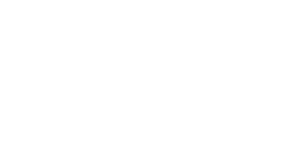

Text(0.04, 0.5, 'Samples')

In [49]:
fig, axes = plt.subplots(num_classes, n_rounds, figsize=(10, 2 * num_classes), sharex=True, sharey=True)
for ax, output in zip(axes, outputs):
    for i in range(n_rounds):
        ax[i].imshow((output[i+1] > 0)[:n_neurons, idx])
        ax[i].set_axis_off()
fig.text(0.5, 0.04, 'Neurons', ha='center', va='center')
fig.text(0.04, 0.5, 'Samples', ha='center', va='center', rotation='vertical')

<IPython.core.display.Javascript object>


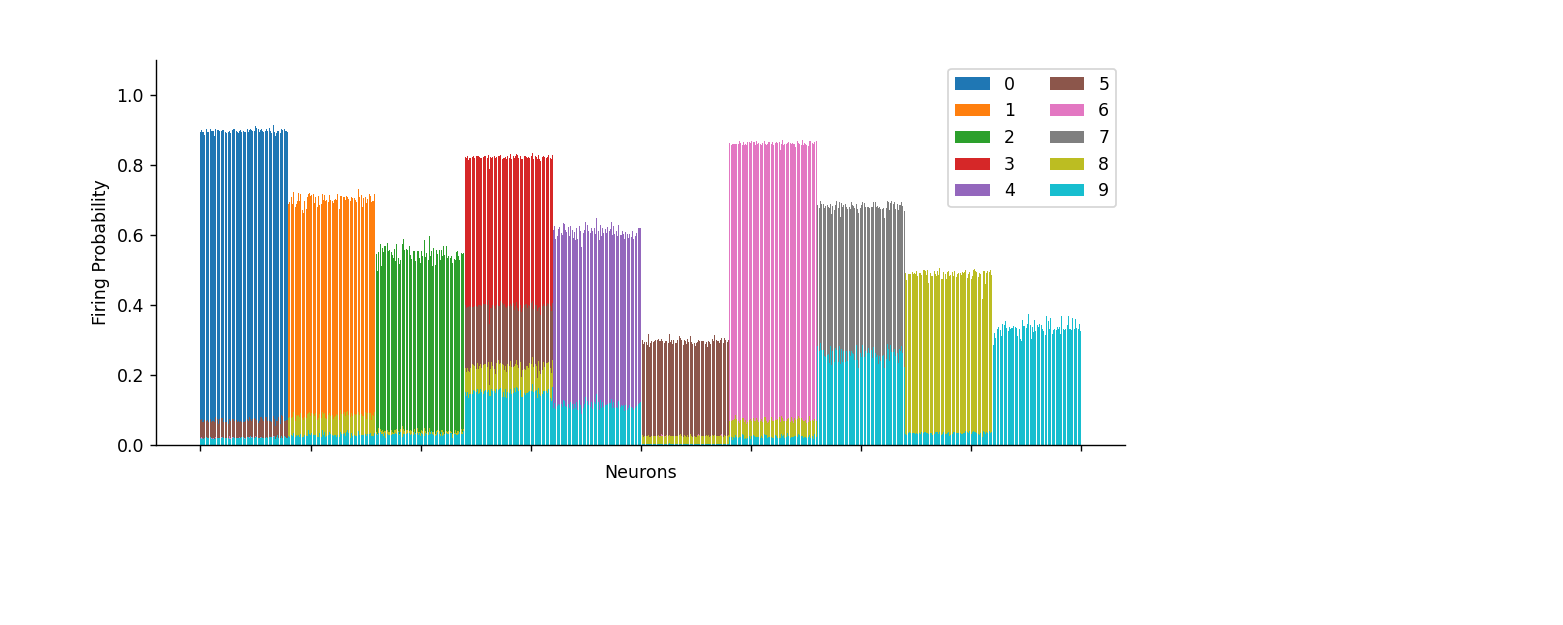

Text(0, 0.5, 'Firing Probability')

In [50]:
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(num_classes):
    # Pass each sample to the model and get its result 
    ax.bar(np.arange(n_neurons), outputs[i, -1].mean(axis=0)[idx], label=i)
ax.legend(loc='upper right', ncol=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0, 1.1])
ax.set_xticklabels([])
ax.set_xlabel('Neurons')
ax.set_ylabel('Firing Probability')

<IPython.core.display.Javascript object>


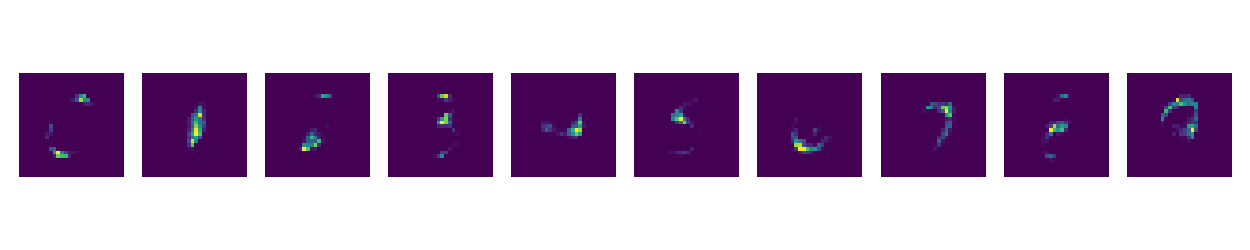

In [35]:
fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    axes[i].imshow((A * c[i][np.newaxis, :]).sum(axis=1).reshape(28, 28))
    axes[i].set_axis_off()
fig.tight_layout()

In [17]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1, keepdims=True)

In [18]:
v = 0.1 * rng.standard_normal((10, n_neurons))
targets = np.zeros((100, 10))

for i in range(10):
    targets[i*10:(i+1)*10, i] = 1
update = np.zeros_like(v)

In [19]:
for _ in range(100):
    permutation = rng.permutation(n_examples - 1000)
    for j in range((n_examples - 1000) // 10):
        batch = outputs[:, 1, permutation[j*10:(j+1)*10]].reshape(10 * 10, n_neurons)
        scores = softmax((batch[:, :, np.newaxis] * v.T[np.newaxis, :, :]).sum(axis=1))
        update = 0.5 * update + 1e-3 * (batch[:, np.newaxis, :] * (scores - targets)[:, :, np.newaxis]).sum(axis=0)
        v -= update

KeyboardInterrupt: 

In [ ]:
((outputs[:, 1, :-1000] @ v.T).argmax(axis=-1) == np.arange(10)[:, np.newaxis]).sum() / 40000

In [ ]:
((outputs[:, 1, -1000:] @ v.T).argmax(axis=-1) == np.arange(10)[:, np.newaxis]).sum() / 10000